<a href="https://colab.research.google.com/github/Manix030/ML_3_lab/blob/main/Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Козлов Максим 23ИИ
3/6

In [11]:
!pip install deepface opencv-python dlib matplotlib > /dev/null 2>&1
print("Библиотеки установлены!")

import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import os
import time

Библиотеки установлены!


In [12]:
# Функция для захвата фотографии с веб-камеры в Google Colab

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Сделать фото';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();

      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')

    display(js)
    data = eval_js('takePhoto({})'.format(quality))

    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    print(f'Фото сохранено: {filename}')
    return filename

In [30]:
# Получение эталонного вектора из уже загруженного фото
# Вариант без веб-камеры — используем готовое изображение

import os
from deepface import DeepFace
import numpy as np

# Имя файла эталона (выбери лучшее фото, где лицо чёткое и прямо)
reference_filename = "2.jpg"           # ← здесь обязательно точка перед jpg!

reference_path = os.path.join("/content", reference_filename)

# Проверка существования файла
if not os.path.exists(reference_path):
    print(f"Ошибка! Файл не найден: {reference_path}")
    print("Доступные файлы в папке:")
    !ls -l /content/sample_data
    print("\nПроверьте точное имя файла (должна быть точка перед jpg)")
else:
    print(f"Эталонное фото найдено: {reference_filename}")
    print(f"Полный путь: {reference_path}\n")

    print("Извлечение вектора признаков (embedding)...")

    try:
        embedding_result = DeepFace.represent(
            img_path=reference_path,
            model_name="Dlib",
            detector_backend="dlib",
            enforce_detection=True,   # если не находит лицо — поставь False
            align=True
        )

        # Берём первое найденное лицо
        reference_embedding = embedding_result[0]["embedding"]
        reference_vector = np.array(reference_embedding)

        print(f"Успешно! Размер вектора: {len(reference_vector)} элементов")
        print("Первые 6 значений:", reference_vector[:6].tolist())

    except Exception as e:
        print("Ошибка извлечения вектора:")
        print(str(e))
        print("\nВозможные решения:")
        print("1. Поставьте enforce_detection=False")
        print("2. Выберите другое фото (например '2.jpg' или '3.jpg')")
        print("3. Перезапустите среду выполнения (Runtime → Restart session)")

Эталонное фото найдено: 2.jpg
Полный путь: /content/2.jpg

Извлечение вектора признаков (embedding)...
Успешно! Размер вектора: 128 элементов
Первые 6 значений: [-0.08019311726093292, 0.07321589440107346, 0.041893310844898224, -0.04926208779215813, -0.09051018208265305, 0.0061880964785814285]


In [31]:
# Верификация на обычном фото + проверка устойчивости к наклону/повороту
# Используем Dlib + Dlib, метрика — евклидово расстояние

from deepface import DeepFace
import os

# Пути (как в твоей папке)
test_normal_path = "/content/5.jpg"      # обычное фото для проверки
tilted_path      = "1.jpg" # фото с наклоном

print("1. ВЕРИФИКАЦИЯ НА ОБЫЧНОМ ФОТО")

try:
    result_normal = DeepFace.verify(
        img1_path=test_normal_path,
        img2_path=reference_path,
        model_name="Dlib",
        detector_backend="dlib",
        distance_metric="euclidean",
        enforce_detection=False,   # чтобы не падало, если лицо найдено неидеально
        align=True,
        silent=True
    )

    distance = result_normal["distance"]
    verified = result_normal["verified"]

    print(f"Фото: {os.path.basename(test_normal_path)}")
    print(f"Евклидово расстояние: {distance:.4f}")
    print(f"Статус: {'ВЕРИФИКАЦИЯ УСПЕШНА' if verified else 'ВЕРИФИКАЦИЯ НЕ УДАЛАСЬ'}")

except Exception as e:
    print("Ошибка при верификации обычного фото:")
    print(str(e))

print("2. ПРОВЕРКА УСТОЙЧИВОСТИ К НАКЛОНУ / ПОВОРОТУ ГОЛОВЫ")

try:
    result_tilt = DeepFace.verify(
        img1_path=tilted_path,
        img2_path=reference_path,
        model_name="Dlib",
        detector_backend="dlib",
        distance_metric="euclidean",
        enforce_detection=False,
        align=True,
        silent=True
    )

    distance_tilt = result_tilt["distance"]
    verified_tilt = result_tilt["verified"]

    print(f"Фото с наклоном: {os.path.basename(tilted_path)}")
    print(f"Евклидово расстояние: {distance_tilt:.4f}")
    print(f"Статус: {'ВЕРИФИКАЦИЯ УСПЕШНА' if verified_tilt else 'ВЕРИФИКАЦИЯ НЕ УДАЛАСЬ'}")

    if verified_tilt:
        print("Вывод: модель достаточно устойчива к такому наклону")
    else:
        print("Вывод: модель чувствительна к такому углу наклона/поворота")
        print("   (типично для Dlib при сильных отклонениях от анфас)")

except Exception as e:
    print("Ошибка при проверке наклона:")
    print(str(e))

1. ВЕРИФИКАЦИЯ НА ОБЫЧНОМ ФОТО
Фото: 5.jpg
Евклидово расстояние: 0.4996
Статус: ВЕРИФИКАЦИЯ УСПЕШНА
2. ПРОВЕРКА УСТОЙЧИВОСТИ К НАКЛОНУ / ПОВОРОТУ ГОЛОВЫ
Фото с наклоном: 1.jpg
Евклидово расстояние: 0.3445
Статус: ВЕРИФИКАЦИЯ УСПЕШНА
Вывод: модель достаточно устойчива к такому наклону


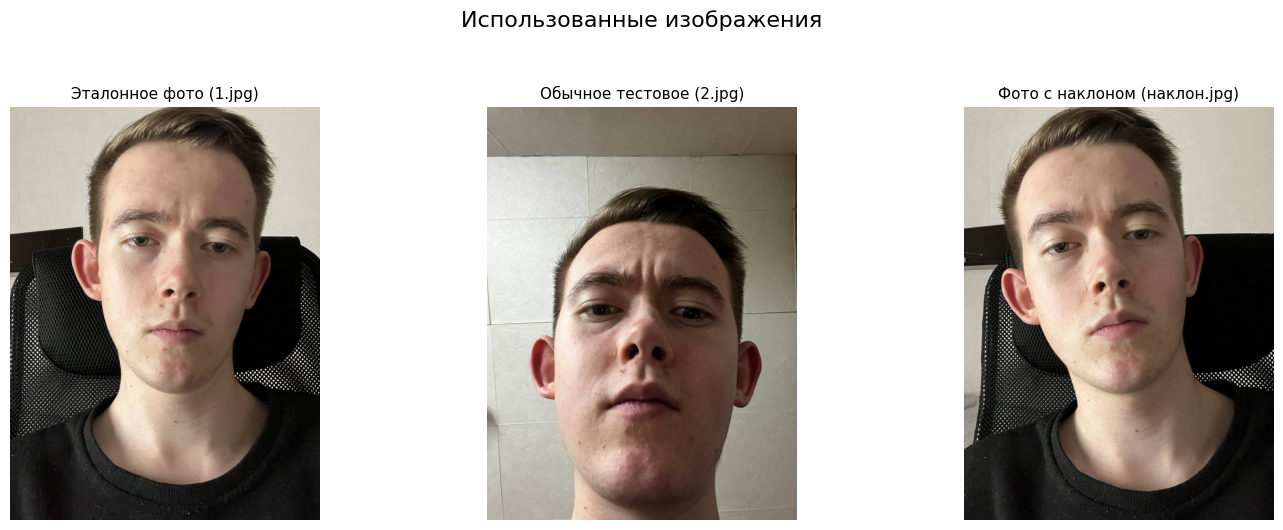

Изображения выведены выше (если файлы найдены)
Эти фото можно использовать в отчёте как иллюстрацию к результатам


In [32]:
# Вывод изображений для наглядности в отчёте
# Эталон + обычное фото + фото с наклоном

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Пути к файлам (те же, что использовались ранее)
images = {
    "Эталонное фото (1.jpg)": "/content/2.jpg",
    "Обычное тестовое (2.jpg)": "/content/5.jpg",
    "Фото с наклоном (наклон.jpg)": "1.jpg"
}

# Настраиваем вывод
plt.figure(figsize=(15, 5))  # ширина × высота в дюймах
plt.suptitle("Использованные изображения", fontsize=16, y=1.05)

for i, (title, path) in enumerate(images.items(), 1):
    if Path(path).exists():
        img = mpimg.imread(path)
        plt.subplot(1, 3, i)
        plt.imshow(img)
        plt.title(title, fontsize=11, wrap=True)
        plt.axis('off')
    else:
        plt.subplot(1, 3, i)
        plt.text(0.5, 0.5, f"Файл не найден:\n{Path(path).name}",
                 ha='center', va='center', color='red', fontsize=10)
        plt.axis('off')

plt.tight_layout()
plt.show()

print("Изображения выведены выше (если файлы найдены)")
print("Эти фото можно использовать в отчёте как иллюстрацию к результатам")